In [14]:
include("../LiPoSID.jl")
using QuantumOptics
basis = NLevelBasis(2)
using LinearAlgebra
using Plots
#using StatsPlots
using Dates
using HDF5

using Statistics

In [2]:
function propagate(A, x0, steps)
    
    x = []
    push!(x, x0)

    @assert size(x0,1) == size(A,1) == size(A,2)

    for i=2:steps
        push!(x, A * x[end])
    end

    return x
end 

function bloch(ρ_list)
    # Pauli matricies
    σ = [ [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1] ]

    bloch_vec = [
        convert.(Float64, [ ρ[1,2]+ρ[2,1],
                           (ρ[1,2]-ρ[2,1])*im,
                            ρ[1,1]-ρ[2,2]       ])
                for ρ in ρ_list]
    hcat(bloch_vec...)
end

function propagate_rho_O1XY(ρ₀, ρᵉᵍˣʸ, steps)

    #hcat(vec[ρᵢ] for ρᵢ in ρᵉᵍˣʸ)

    kᵉᵍˣʸ = hcat([vec(ρᵢ[1]) for ρᵢ in ρᵉᵍˣʸ]...)\vec(ρ₀)

    kᵉ, kᵍ, kˣ, kʸ = kᵉᵍˣʸ              
    ρᵉ, ρᵍ, ρˣ, ρʸ = ρᵉᵍˣʸ

    steps = min(length(ρᵉ), length(ρᵍ), length(ρˣ), length(ρʸ))

    ρ = kᵉ * ρᵉ[1:steps] + kᵍ * ρᵍ[1:steps] + kˣ * ρˣ[1:steps] + kʸ * ρʸ[1:steps]

    return ρ
end 

propagate_rho_O1XY (generic function with 1 method)

In [17]:
function SBvs4DBlochDMD_basis(γᵢ)

    data_dir = "../DATA/"

    γᵢ = string(γᵢ)

    tᵍᵉˣʸ , ρᵍᵉˣʸ  = LiPoSID.read_GEXY_timeevolution(evol_data_file_name, γᵢ)

    ρᵍ, ρᵉ, ρˣ, ρʸ = ρᵍᵉˣʸ
    tᵍ, tᵉ, tˣ, tʸ = tᵍᵉˣʸ

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    bᵉ = bloch(ρᵉ[1:lᵐᵃˣ])
    bᵍ = bloch(ρᵍ[1:lᵐᵃˣ])
    bˣ = bloch(ρˣ[1:lᵐᵃˣ])
    bʸ = bloch(ρʸ[1:lᵐᵃˣ])

    tᵉᶠ = convert.(Float64, tᵉ); tᵍᶠ = convert.(Float64, tᵍ); 
    tˣᶠ = convert.(Float64, tˣ); tʸᶠ = convert.(Float64, tʸ); 

    t_list = [tᵉᶠ, tᵍᶠ, tˣᶠ, tʸᶠ]

    Δt = tᵉᶠ[2] - tᵉᶠ[1]

    t = t_list[argmin(length(tⁱ) for tⁱ in t_list)]
    
    ρˢᵇ = [ρᵉ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ]]

    Yᵉ = [bᵉ; ones(lᵐᵃˣ)']
    Yᵍ = [bᵍ; ones(lᵐᵃˣ)']
    Yˣ = [bˣ; ones(lᵐᵃˣ)']
    Yʸ = [bʸ; ones(lᵐᵃˣ)']

    Yᵉ⁻ = Yᵉ[:,1:end-1]; Yᵉ⁺ = Yᵉ[:,2:end]
    Yᵍ⁻ = Yᵍ[:,1:end-1]; Yᵍ⁺ = Yᵍ[:,2:end]
    Yˣ⁻ = Yˣ[:,1:end-1]; Yˣ⁺ = Yˣ[:,2:end]
    Yʸ⁻ = Yᵉ[:,1:end-1]; Yʸ⁺ = Yᵉ[:,2:end]

    Y⁻ = hcat(Yᵉ⁻, Yᵍ⁻, Yˣ⁻, Yʸ⁻)
    Y⁺ = hcat(Yᵉ⁺, Yᵍ⁺, Yˣ⁺, Yʸ⁺)

    A⁴ᴰ = Y⁺ * pinv(Y⁻) # Direct DMD estimation

    A⁴ᴰc = log(A⁴ᴰ)/Δt
    
    bᵉ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bᵉ[:,1]...,1], lᵐᵃˣ)...)[1:3,:] 
    bᵍ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bᵍ[:,1]...,1], lᵐᵃˣ)...)[1:3,:]
    bˣ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bˣ[:,1]...,1], lᵐᵃˣ)...)[1:3,:]
    bʸ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bʸ[:,1]...,1], lᵐᵃˣ)...)[1:3,:]

    ρᵉ⁴ᴰ = LiPoSID.rho_series_from_bloch(bᵉ⁴ᴰ) 
    ρᵍ⁴ᴰ = LiPoSID.rho_series_from_bloch(bᵍ⁴ᴰ)
    ρˣ⁴ᴰ = LiPoSID.rho_series_from_bloch(bˣ⁴ᴰ)
    ρʸ⁴ᴰ = LiPoSID.rho_series_from_bloch(bʸ⁴ᴰ)

    ρᴮ⁴ᴰᴹᴰ = [ρᵉ⁴ᴰ, ρᵍ⁴ᴰ, ρˣ⁴ᴰ, ρʸ⁴ᴰ]

    Δt = t[2] - t[1]

    
    return ρˢᵇ, ρᴮ⁴ᴰᴹᴰ, t[1:lᵐᵃˣ], A⁴ᴰc

end

SBvs4DBlochDMD_basis (generic function with 1 method)

In [11]:
parentdir = ".."
data_dir = parentdir*"/DATA/"
println(data_dir)

models_dir = parentdir*"/MODELS/"
tests_dir = "" #parentdir*"/TESTS/"

dodeca_files = ["D"*string(n) for n=1:10];
basis_files = ["B"*string(n) for n=1:4];

all_files = vcat(dodeca_files, basis_files)
test_states = dodeca_files;

evol_data_file_name = "../DATA/ALL_GAMMAS_B4_D10.h5"

../DATA/


"../DATA/ALL_GAMMAS_B4_D10.h5"

In [23]:
date_and_time_string =  string(Dates.format(now(), "yyyy-u-dd_at_HH-MM"))

tests_data_file_name = "DMD-Bloch4D_SB_trn4_tst20_"*date_and_time_string * ".h5"

println(tests_data_file_name)

γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

#γ = ["0.0", "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

FminGammas = []
FmedianGammas = []
FmeanGammas = []
PositiveEvals = []

for γᵢ in  γ

    ρˢᵇ, ρᴮ⁴ᴰᴹᴰ, t, A⁴ᴰc = SBvs4DBlochDMD_basis(γᵢ)

    evals, evecs = eigen(A⁴ᴰc)

    if isempty(evals[real.(evals).>0])
        maxposeval = 0
    else
        maxposeval = maximum(real.(evals[real.(evals).>0]))
    end

    push!(PositiveEvals, maxposeval)

    h5open(tests_dir*tests_data_file_name,"cw") do fid
        γ_group = create_group(fid, γᵢ) # create coupling group
        γ_group["Ac"] = A⁴ᴰc
        γ_group["max_pos_eigenval"] = maxposeval
    end 

    println()
    println("γᵢ = ", γᵢ)

    ρᵉˢᵇ, ρᵍˢᵇ, ρˣˢᵇ, ρʸˢᵇ = ρˢᵇ
    ρᵉᴮ⁴ᴰᴹᴰ, ρᵍᴮ⁴ᴰᴹᴰ, ρˣᴮ⁴ᴰᴹᴰ, ρʸᴮ⁴ᴰᴹᴰ = ρᴮ⁴ᴰᴹᴰ

    FminStates = []
    FmedianStates = []
    FmeanStates = []

    for state in test_states # loop over initial states
        
        print(state*" ")

        tᵗˢᵗ, ρᵗˢᵗ = LiPoSID.read_timeevolution(evol_data_file_name, state, γᵢ)

        if length(tᵗˢᵗ) > 1200 end_tst = 1200 else end_tst = length(tᵗˢᵗ) end

        tᵗˢᵗᶠ = convert.(Float64, tᵗˢᵗ)

        steps = min(end_tst, length(t))

        ρᵗˢᵗᴮ⁴ᴰᴹᴰ =  propagate_rho_O1XY(ρᵗˢᵗ[1], ρᴮ⁴ᴰᴹᴰ, steps)

        Fᴮ⁴ᴰᴹᴰ = LiPoSID.fidelity_series(basis, ρᵗˢᵗᴮ⁴ᴰᴹᴰ[1:steps], ρᵗˢᵗ[1:steps])

        h5open(tests_dir*tests_data_file_name,"cw") do fid
            γ_group = open_group(fid, γᵢ) # create coupling group
            state_group = create_group(γ_group, state) # create coupling group
            state_group["Fidelity"] = convert.(Float64, Fᴮ⁴ᴰᴹᴰ)
            state_group["time"] = convert.(Float64, tᵗˢᵗ[1:steps]) 
        end

        FminState = minimum(Fᴮ⁴ᴰᴹᴰ)
        FmedianState = mean(Fᴮ⁴ᴰᴹᴰ)
        FmeanState = mean(Fᴮ⁴ᴰᴹᴰ)
        
        push!(FminStates, FminState)
        push!(FmedianStates, FmedianState)
        push!(FmeanStates, FmeanState)

    end

        # Calculate the mean
        F_mean_value = mean(FmeanStates)

        # Calculate the median
        F_median_value = median(FmedianStates)
    
        # Calculate the min
        F_min_value = minimum(FminStates)
    
        push!(FminGammas, F_min_value)
        push!(FmedianGammas, F_median_value)
        push!(FmeanGammas, F_mean_value)
    
        println("Median fidelity for "*γᵢ*": ", F_median_value)
        
end

DMD-Bloch4D_SB_trn4_tst20_2024-Sep-16_at_14-41.h5

γᵢ = 0.079477
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 0.079477: 0.999999764502224

γᵢ = 0.25133
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 0.25133: 0.9999998514776614

γᵢ = 0.79477
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 0.79477: 0.9999990599814211

γᵢ = 2.5133
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 2.5133: 0.9999938701993294

γᵢ = 7.9477
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 7.9477: 0.9998870079908934

γᵢ = 25.133
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 25.133: 0.9958273667833694

γᵢ = 79.477
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 79.477: 0.997920753924531

γᵢ = 251.33
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 251.33: 0.9199199656994039


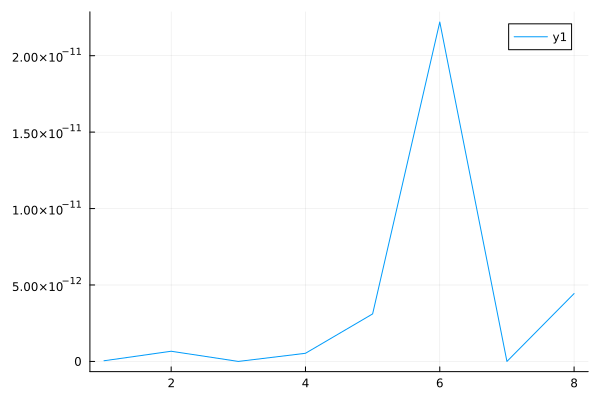

In [24]:
plot(PositiveEvals)

In [25]:
using PyCall

# Import the pickle module from Python
pickle = pyimport("pickle")

# Use Python's built-in open function to open the file in binary write mode
pyopen = pyimport("builtins").open

# Open a file in write-binary mode using Python's open function
file = pyopen("PositiveEigenVals.pkl", "wb")

# Use pickle's dump function to save the array
pickle.dump(PositiveEvals, file) #NaN16

# Close the file
file.close()